In [8]:
import anndata as ad
import numpy as np
import torch
from image_generators.SOM.SOM import SOM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
adata = ad.read_h5ad("/nobackup/scmpht/CNN-seq/data/model_ready/dummy_GTEx.h5ad")
adata = adata[adata.obs['split'] == 'train']
adata

View of AnnData object with n_obs × n_vars = 1566 × 1539
    obs: 'SMTS', 'SMTSD', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH', 'SMGEBTCHD', 'SMGEBTCHT', 'SMCENTER', 'split'
    var: 'Symbol'

In [3]:
adata.X.T.shape

(1539, 1566)

In [4]:
# Z-score inputs
scaler = StandardScaler()
X = torch.from_numpy(scaler.fit_transform(adata.X))

In [6]:
# Training grid
m = 32
n = 32
dim = X.shape[1]

# Instatiate SOM
som = SOM(m, n, dim, decay=0.95, alpha=0.3)


max_iter = 200
alpha = 0.3
best_objective = np.inf
patience = 0
tolerance = 0.01 * som.get_avg_bmu_dist(X).numpy() # 1% of initial distances

def objective_function(distance, changes, alpha=1, beta=1):
    return distance*alpha + changes*beta


best_objectives = np.array([])
avg_distances = np.array([])
num_changes = np.array([])

bmu_list = som.get_bmus(X)

for iter_no in range(max_iter):
    
    # 1) Perform the training update for this iteration
    for i in range(len(X)):
        som(X[i], iter_no)
    
    # 2) Compute new average distance
    this_avg_dist = som.get_avg_bmu_dist(X).numpy()
    avg_distances = np.append(avg_distances, this_avg_dist)

    # 3) Compute new changes
    bmu_list, changes = som.get_bmu_changes(X, bmu_list)
    num_changes = np.append(num_changes, changes)

    # 4) Compute objective
    objective = objective_function(this_avg_dist, changes, alpha=1, beta=0.001)

    # 5) Check patience
    if objective < best_objective - tolerance:
        best_objective = objective
        patience = 0
    else:
        patience += 1

    best_objectives = np.append(best_objectives, best_objective)
    if patience == 2:
        break
    
    print(f"Iteration: {iter_no} | Average distance: {this_avg_dist} | No. of changes: {changes} | Objective: {best_objective}")

Iteration: 0 | Average distance: 30.282293720985162 | No. of changes: [1565.] | Objective: 31.847293720985164
Iteration: 1 | Average distance: 30.00667398295611 | No. of changes: [1565. 1265.] | Objective: 31.27167398295611
Iteration: 2 | Average distance: 29.746923273728825 | No. of changes: [1565. 1265. 1313.] | Objective: 31.27167398295611
Iteration: 3 | Average distance: 28.97772670398477 | No. of changes: [1565. 1265. 1313. 1466.] | Objective: 30.443726703984773
Iteration: 4 | Average distance: 29.067927749000198 | No. of changes: [1565. 1265. 1313. 1466. 1421.] | Objective: 30.443726703984773
Iteration: 5 | Average distance: 28.724277660805264 | No. of changes: [1565. 1265. 1313. 1466. 1421. 1270.] | Objective: 29.994277660805263
Iteration: 6 | Average distance: 28.53144606928067 | No. of changes: [1565. 1265. 1313. 1466. 1421. 1270. 1380.] | Objective: 29.994277660805263
Iteration: 7 | Average distance: 27.44321669871896 | No. of changes: [1565. 1265. 1313. 1466. 1421. 1270. 138

KeyboardInterrupt: 

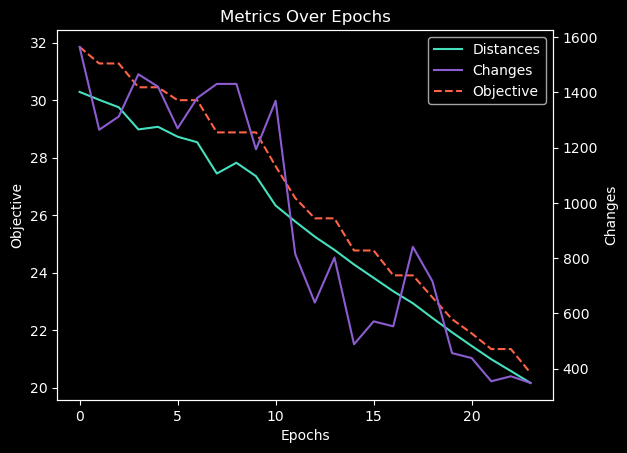

In [9]:
fig, ax1 = plt.subplots()

# Plot avg_distances on the first axis (separate y-axis)
p1, = ax1.plot(avg_distances, c="#46e0bf", label="Distances")
ax1.set_ylabel('Objective')
ax1.tick_params(axis='y')
ax1.set_xlabel('Epochs')



# Add a second y-axis for num_changes and best_objective
ax2 = ax1.twinx()

# Plot num_changes and best_objective on the same axis
p2, = ax2.plot(num_changes, c="#8c5dd0", label="Changes", linestyle='-')
p3, = ax1.plot(best_objectives, c="#ff6347", label="Objective", linestyle='--')

# Set labels for ax2
ax2.set_ylabel('Changes')
ax2.tick_params(axis='y')

# Add a combined legend for all metrics
lines = [p1, p2, p3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

# Add a title
plt.title("Metrics Over Epochs")
plt.show()